<a href="https://colab.research.google.com/github/DCM2002/Telecom-Customer-Churn/blob/main/Telecom_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier


# Load the CSV file
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [3]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [4]:
df_cat= df.select_dtypes(exclude=["number","bool_","float"])
df_cat.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


In [5]:
df_num=df.select_dtypes(exclude=["object_","bool_"])
df_num.head()

,SeniorCitizen,tenure,MonthlyCharges
0,0,1,29.85
1,0,34,56.95
2,0,2,53.85
3,0,45,42.30
4,0,2,70.70


Q1 - Which customer has highest probability to switch to another telecom (known as churn)

Q2 - What could be the plausible reason why churn is happening

Q3 - How good the prediction is? Can we reply on this predictive analytics

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

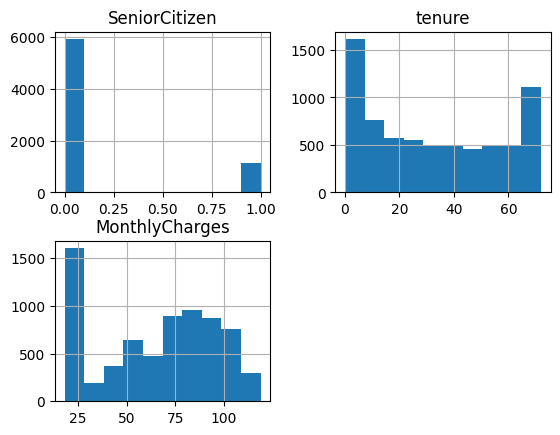

In [6]:
df_num.hist()

<ipython-input-7-eaf17ef51a14>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype('category').cat.codes  # Convert categorical to numeric
<ipython-input-7-eaf17ef51a14>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype('category').cat.codes  # Convert categorical to numeric
<ipython-input-7-eaf17ef51a14>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Categorical Features Correlation with Churn:
gender: -0.008544643224946389
Partner: -0.14998192562005871
Dependents: -0.16312843938822014
PhoneService: 0.011691398865421573
MultipleLines: 0.03804327435621396
InternetService: -0.04709716459089994
OnlineSecurity: -0.2890501761175903
OnlineBackup: -0.19529020856666426
DeviceProtection: -0.17788319529016144
TechSupport: -0.28223248660266
StreamingTV: -0.036302721512460265
StreamingMovies: -0.03880174840533733
Contract: -0.39614953299365374
PaperlessBilling: 0.19145432108004576
PaymentMethod: 0.10785201511046909

Numerical Features Correlation with Churn:
SeniorCitizen     0.150541
tenure           -0.354049
MonthlyCharges    0.192858
Name: Churn, dtype: float64


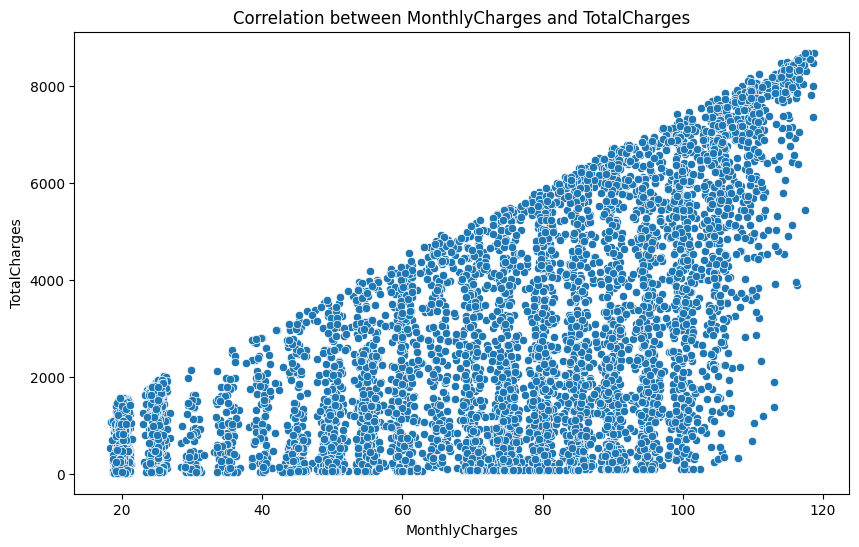

In [7]:
# Convert 'Churn' to binary (Yes = 1, No = 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert 'TotalCharges' to numeric (handle non-numeric values)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing values in 'TotalCharges'
df = df.dropna(subset=['TotalCharges'])

# Separate categorical and numerical features
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                        'PaperlessBilling', 'PaymentMethod']
numerical_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges']

# Calculate Point-Biserial Correlation for categorical features with 'Churn'
categorical_correlations = {}
for feature in categorical_features:
    df[feature] = df[feature].astype('category').cat.codes  # Convert categorical to numeric
    corr, _ = stats.pointbiserialr(df[feature], df['Churn'])
    categorical_correlations[feature] = corr

# Calculate Pearson Correlation for numerical features with 'Churn'
numerical_correlations = df[numerical_features + ['Churn']].corr()['Churn'].drop('Churn')

# Print the correlations
print("Categorical Features Correlation with Churn:")
for feature, corr in categorical_correlations.items():
    print(f"{feature}: {corr}")

print("\nNumerical Features Correlation with Churn:")
print(numerical_correlations)

# Visualize the correlation between 'MonthlyCharges' and 'TotalCharges'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', data=df)
plt.title('Correlation between MonthlyCharges and TotalCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.show()


In [8]:
#due to monthlychargers having one of the highest co relations with churn and total chargers to avoid any data leakagers we are droppping the monthlychargers column
df.drop('MonthlyCharges',axis=1,inplace=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,151.65,1


array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'Partner'}>,
        <Axes: title={'center': 'Dependents'}>],
       [<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'PhoneService'}>,
        <Axes: title={'center': 'MultipleLines'}>,
        <Axes: title={'center': 'InternetService'}>],
       [<Axes: title={'center': 'OnlineSecurity'}>,
        <Axes: title={'center': 'OnlineBackup'}>,
        <Axes: title={'center': 'DeviceProtection'}>,
        <Axes: title={'center': 'TechSupport'}>],
       [<Axes: title={'center': 'StreamingTV'}>,
        <Axes: title={'center': 'StreamingMovies'}>,
        <Axes: title={'center': 'Contract'}>,
        <Axes: title={'center': 'PaperlessBilling'}>],
       [<Axes: title={'center': 'PaymentMethod'}>,
        <Axes: title={'center': 'TotalCharges'}>,
        <Axes: title={'center': 'Churn'}>, <Axes: >]], dtype=object)

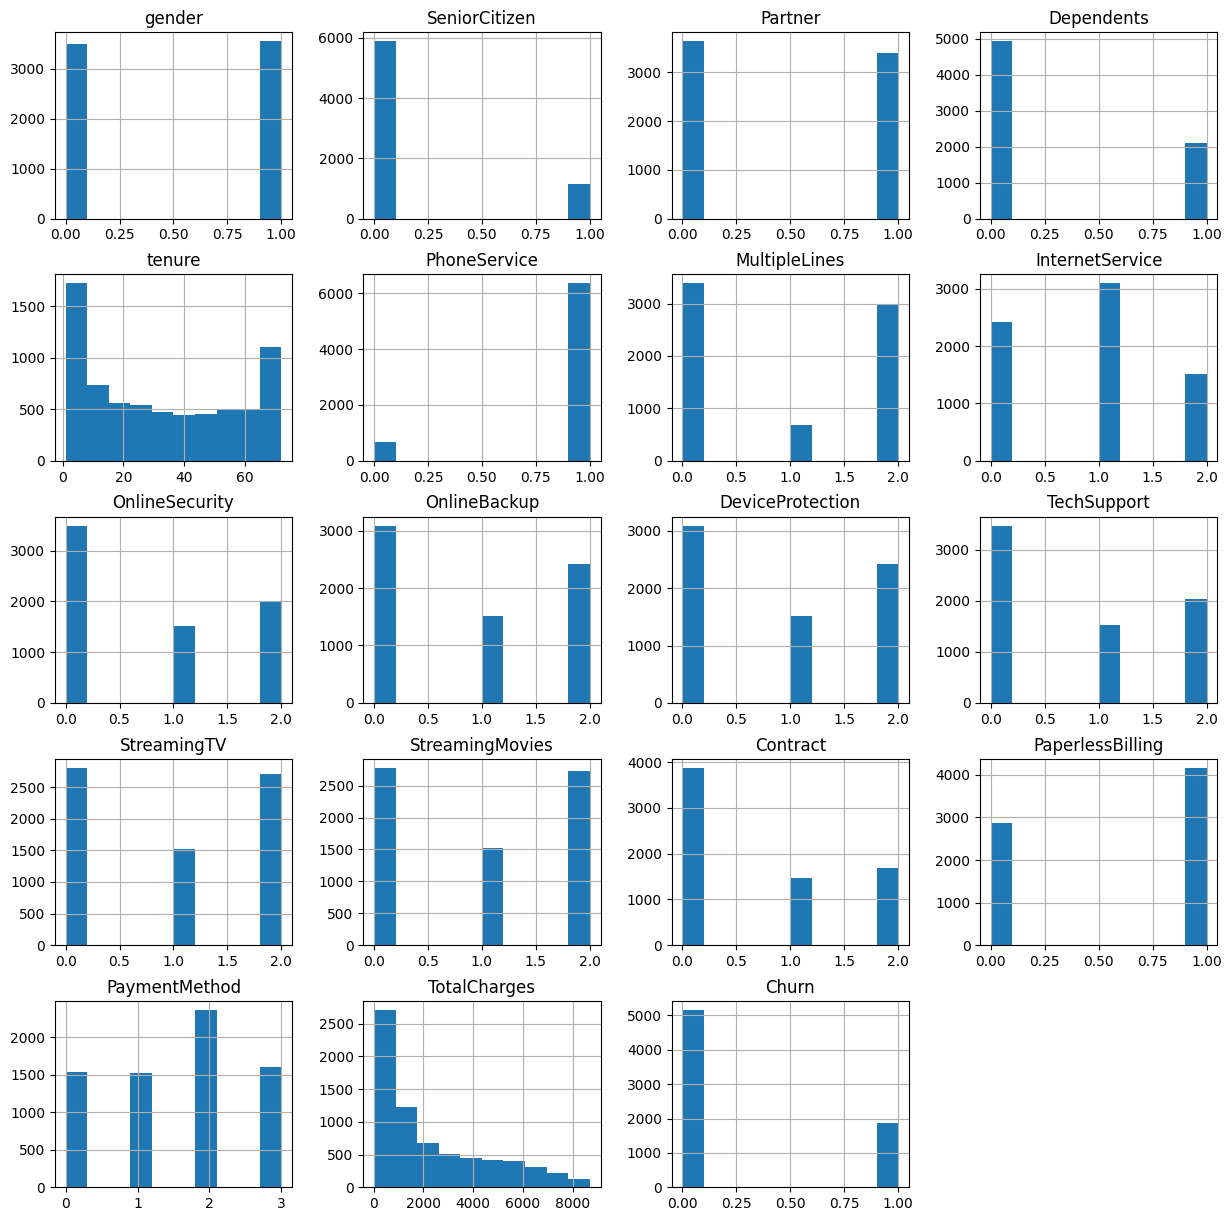

In [9]:
df.hist(figsize=(15,15))

In [10]:
churn_counts = df['Churn'].value_counts()
print(churn_counts)

Churn
0    5163
1    1869
Name: count, dtype: int64


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   int8   
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   int8   
 4   Dependents        7032 non-null   int8   
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   int8   
 7   MultipleLines     7032 non-null   int8   
 8   InternetService   7032 non-null   int8   
 9   OnlineSecurity    7032 non-null   int8   
 10  OnlineBackup      7032 non-null   int8   
 11  DeviceProtection  7032 non-null   int8   
 12  TechSupport       7032 non-null   int8   
 13  StreamingTV       7032 non-null   int8   
 14  StreamingMovies   7032 non-null   int8   
 15  Contract          7032 non-null   int8   
 16  PaperlessBilling  7032 non-null   int8   
 17  

In [12]:
drop_cols=['customerID']
df.drop(drop_cols,axis=1,inplace=True)

In [13]:
record_count=df.shape[0]
print(record_count)

7032


In [14]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Get the number of records after dropping duplicates
record_count = df.shape[0]
print(f"Number of records after dropping duplicates: {record_count}")


Number of duplicate rows: 22
Number of records after dropping duplicates: 7010


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the features (X) and the target variable (y)
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames for easier handling (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Print the first few rows of the scaled training and testing sets to verify
print("Scaled Training Data:")
print(X_train_scaled.head())

print("\nScaled Testing Data:")
print(X_test_scaled.head())


Scaled Training Data:
     gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
0 -1.001785       2.270655 -0.969786   -0.653709 -0.672489      0.329755   
1 -1.001785      -0.440402 -0.969786   -0.653709 -1.287204     -3.032551   
2 -1.001785      -0.440402  1.031156   -0.653709  1.335580      0.329755   
3 -1.001785      -0.440402 -0.969786   -0.653709 -1.287204     -3.032551   
4  0.998218       2.270655  1.031156   -0.653709  0.147131      0.329755   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0       1.104686        -1.177071        1.404274     -1.026997   
1       0.050384        -1.177071       -0.913315     -1.026997   
2       1.104686         0.185649       -0.913315      1.236028   
3       0.050384        -1.177071       -0.913315     -1.026997   
4       1.104686         0.185649       -0.913315     -1.026997   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0         -1.027357    -0.920716    -1.113

In [16]:
X_train.info()
X_train.isnull().sum()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5608 entries, 356 to 1771
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5608 non-null   int8   
 1   SeniorCitizen     5608 non-null   int64  
 2   Partner           5608 non-null   int8   
 3   Dependents        5608 non-null   int8   
 4   tenure            5608 non-null   int64  
 5   PhoneService      5608 non-null   int8   
 6   MultipleLines     5608 non-null   int8   
 7   InternetService   5608 non-null   int8   
 8   OnlineSecurity    5608 non-null   int8   
 9   OnlineBackup      5608 non-null   int8   
 10  DeviceProtection  5608 non-null   int8   
 11  TechSupport       5608 non-null   int8   
 12  StreamingTV       5608 non-null   int8   
 13  StreamingMovies   5608 non-null   int8   
 14  Contract          5608 non-null   int8   
 15  PaperlessBilling  5608 non-null   int8   
 16  PaymentMethod     5608 non-null   int8   
 17

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
356,0,1,0,0,16,1,2,0,2,0,0,0,0,0,0,1,2,889.00
211,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,25.25
2594,0,0,1,0,65,1,2,1,0,2,2,2,2,2,2,1,0,7082.85
4641,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,3,24.40
2521,1,1,1,0,36,1,2,1,0,0,0,0,0,2,0,1,1,3132.75


In [17]:
X_test.info()
X_test.isnull().sum()
X_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 744 to 3415
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            1402 non-null   int8   
 1   SeniorCitizen     1402 non-null   int64  
 2   Partner           1402 non-null   int8   
 3   Dependents        1402 non-null   int8   
 4   tenure            1402 non-null   int64  
 5   PhoneService      1402 non-null   int8   
 6   MultipleLines     1402 non-null   int8   
 7   InternetService   1402 non-null   int8   
 8   OnlineSecurity    1402 non-null   int8   
 9   OnlineBackup      1402 non-null   int8   
 10  DeviceProtection  1402 non-null   int8   
 11  TechSupport       1402 non-null   int8   
 12  StreamingTV       1402 non-null   int8   
 13  StreamingMovies   1402 non-null   int8   
 14  Contract          1402 non-null   int8   
 15  PaperlessBilling  1402 non-null   int8   
 16  PaymentMethod     1402 non-null   int8   
 17

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges
744,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,1,1,202.15
669,0,0,1,0,70,0,1,0,0,2,2,2,2,2,2,0,0,4039.30
5764,1,1,0,0,57,1,2,1,2,0,0,2,0,2,2,0,2,5625.55
5469,1,0,0,0,33,1,0,1,0,2,2,0,0,0,0,1,1,2576.80
2030,1,0,0,1,2,1,2,0,2,2,0,0,0,0,0,0,0,134.60


or we can use statifiedKfold

In [18]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Fit and apply the SMOTE transformation on the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Convert the balanced arrays back to DataFrames for easier handling (optional)
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
y_train_balanced = pd.Series(y_train_balanced, name='Churn')

# Print the class distribution before and after balancing
print("Class distribution before balancing:")
print(Counter(y_train))

print("\nClass distribution after balancing:")
print(Counter(y_train_balanced))

# Print the first few rows of the balanced training data to verify
print("\nBalanced Training Data:")
print(X_train_balanced.head())
print(y_train_balanced.head())


Class distribution before balancing:
Counter({0: 4122, 1: 1486})

Class distribution after balancing:
Counter({0: 4122, 1: 4122})

Balanced Training Data:
     gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
0 -1.001785       2.270655 -0.969786   -0.653709 -0.672489      0.329755   
1 -1.001785      -0.440402 -0.969786   -0.653709 -1.287204     -3.032551   
2 -1.001785      -0.440402  1.031156   -0.653709  1.335580      0.329755   
3 -1.001785      -0.440402 -0.969786   -0.653709 -1.287204     -3.032551   
4  0.998218       2.270655  1.031156   -0.653709  0.147131      0.329755   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0       1.104686        -1.177071        1.404274     -1.026997   
1       0.050384        -1.177071       -0.913315     -1.026997   
2       1.104686         0.185649       -0.913315      1.236028   
3       0.050384        -1.177071       -0.913315     -1.026997   
4       1.104686         0.185649       -0.913315    

In [34]:
# Initialize the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the classifier on the balanced training data
gb_classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_gb= gb_classifier.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_gb))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1031
           1       0.57      0.67      0.61       371

    accuracy                           0.78      1402
   macro avg       0.72      0.74      0.73      1402
weighted avg       0.79      0.78      0.78      1402


Confusion Matrix:
[[844 187]
 [124 247]]

Accuracy Score: 0.7781740370898717


In [36]:
# Initialize the SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the classifier on the balanced training data
svm_classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_svm = svm_classifier.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred_svm))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1031
           1       0.48      0.84      0.61       371

    accuracy                           0.72      1402
   macro avg       0.70      0.76      0.70      1402
weighted avg       0.81      0.72      0.74      1402


Confusion Matrix:
[[697 334]
 [ 59 312]]

Accuracy Score: 0.7196861626248217


In [26]:
# Initialize the Random Forest Classifier
rfcl = RandomForestClassifier(random_state=42)

# Train the classifier on the balanced training data
rfcl.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred = rfcl.predict(X_test_scaled)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1031
           1       0.58      0.54      0.56       371

    accuracy                           0.77      1402
   macro avg       0.71      0.70      0.70      1402
weighted avg       0.77      0.77      0.77      1402


Confusion Matrix:
[[884 147]
 [170 201]]

Accuracy Score: 0.7738944365192582


In [27]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN Classifier
knn = KNeighborsClassifier(n_neighbors=6)

# Train the classifier on the balanced training data
knn.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_knn = knn.predict(X_test_scaled)

# Evaluate the model
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nKNN Accuracy Score:", accuracy_score(y_test, y_pred_knn))



KNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1031
           1       0.50      0.67      0.57       371

    accuracy                           0.74      1402
   macro avg       0.68      0.72      0.69      1402
weighted avg       0.77      0.74      0.75      1402


KNN Confusion Matrix:
[[788 243]
 [124 247]]

KNN Accuracy Score: 0.7382310984308131


In [28]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the classifier on the balanced training data
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_dt = dt.predict(X_test_scaled)

# Evaluate the model
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("\nDecision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nDecision Tree Accuracy Score:", accuracy_score(y_test, y_pred_dt))



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1031
           1       0.50      0.55      0.52       371

    accuracy                           0.73      1402
   macro avg       0.66      0.67      0.67      1402
weighted avg       0.74      0.73      0.74      1402


Decision Tree Confusion Matrix:
[[824 207]
 [167 204]]

Decision Tree Accuracy Score: 0.7332382310984308


In [52]:
# Initialize the Logistic Regression Classifier
lr_classifier = LogisticRegression(random_state=42)

# Train the classifier on the balanced training data
lr_classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_lr = lr_classifier.predict(X_test_scaled)
y_scores_lr = lr_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nLogistic Regression Accuracy Score:", accuracy_score(y_test, y_pred_lr))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1031
           1       0.51      0.80      0.62       371

    accuracy                           0.74      1402
   macro avg       0.71      0.76      0.71      1402
weighted avg       0.80      0.74      0.76      1402


Logistic Regression Confusion Matrix:
[[742 289]
 [ 73 298]]

Logistic Regression Accuracy Score: 0.7417974322396577


In [53]:
# Initialize the Dummy Classifier (Base Estimator)
dummy_classifier = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the classifier on the balanced training data
dummy_classifier.fit(X_train_balanced, y_train_balanced)

# Make predictions on the testing data
y_pred_dummy = dummy_classifier.predict(X_test_scaled)

# Evaluate the model
print("\nDummy Classifier Classification Report:")
print(classification_report(y_test, y_pred_dummy))

print("\nDummy Classifier Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))

print("\nDummy Classifier Accuracy Score:", accuracy_score(y_test, y_pred_dummy))



Dummy Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1031
           1       0.00      0.00      0.00       371

    accuracy                           0.74      1402
   macro avg       0.37      0.50      0.42      1402
weighted avg       0.54      0.74      0.62      1402


Dummy Classifier Confusion Matrix:
[[1031    0]
 [ 371    0]]

Dummy Classifier Accuracy Score: 0.7353780313837375


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


classifiers should have a higher recall.
TP/TP+FN

In [37]:
# Store precision and recall for each classifier
classifiers = ['Gradient Boosting', 'SVM', 'KNN', 'Decision Tree']
precision_scores = []
recall_scores = []

# Gradient Boosting
precision_gb = classification_report(y_test, y_pred_gb, output_dict=True)['1']['precision']
recall_gb = classification_report(y_test, y_pred_gb, output_dict=True)['1']['recall']
precision_scores.append(precision_gb)
recall_scores.append(recall_gb)

# SVM
precision_svm = classification_report(y_test, y_pred_svm, output_dict=True)['1']['precision']
recall_svm = classification_report(y_test, y_pred_svm, output_dict=True)['1']['recall']
precision_scores.append(precision_svm)
recall_scores.append(recall_svm)

# KNN
precision_knn = classification_report(y_test, y_pred_knn, output_dict=True)['1']['precision']
recall_knn = classification_report(y_test, y_pred_knn, output_dict=True)['1']['recall']
precision_scores.append(precision_knn)
recall_scores.append(recall_knn)

# Decision Tree
precision_dt = classification_report(y_test, y_pred_dt, output_dict=True)['1']['precision']
recall_dt = classification_report(y_test, y_pred_dt, output_dict=True)['1']['recall']
precision_scores.append(precision_dt)
recall_scores.append(recall_dt)


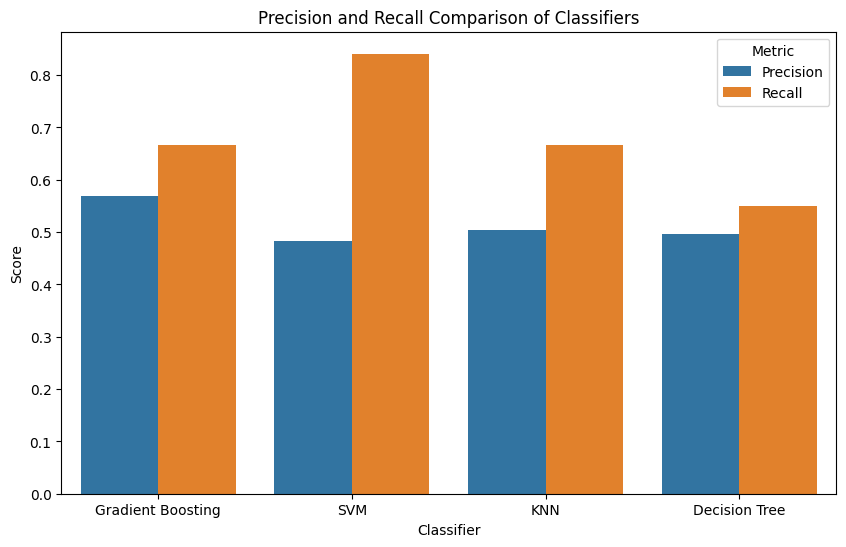

In [38]:
# Create a DataFrame for visualization
comparison_df = pd.DataFrame({
    'Classifier': classifiers,
    'Precision': precision_scores,
    'Recall': recall_scores
})

# Melt the DataFrame for easier plotting
comparison_df_melted = comparison_df.melt(id_vars='Classifier', var_name='Metric', value_name='Score')

# Plot the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Score', hue='Metric', data=comparison_df_melted)
plt.title('Precision and Recall Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()


In [40]:
# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


In [41]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.', label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [42]:
# Get predicted probabilities for each classifier
y_scores_gb = gb_classifier.predict_proba(X_test_scaled)[:, 1]
y_scores_svm = svm_classifier.decision_function(X_test_scaled)
y_scores_knn = knn.predict_proba(X_test_scaled)[:, 1]
y_scores_dt = dt.predict_proba(X_test_scaled)[:, 1]


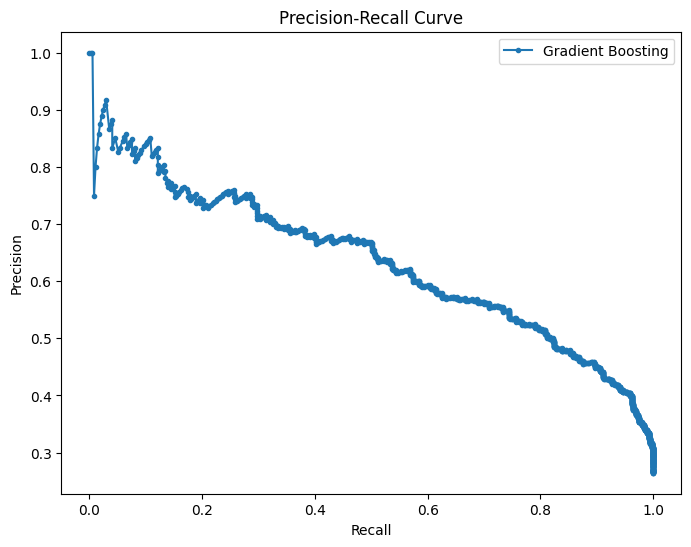

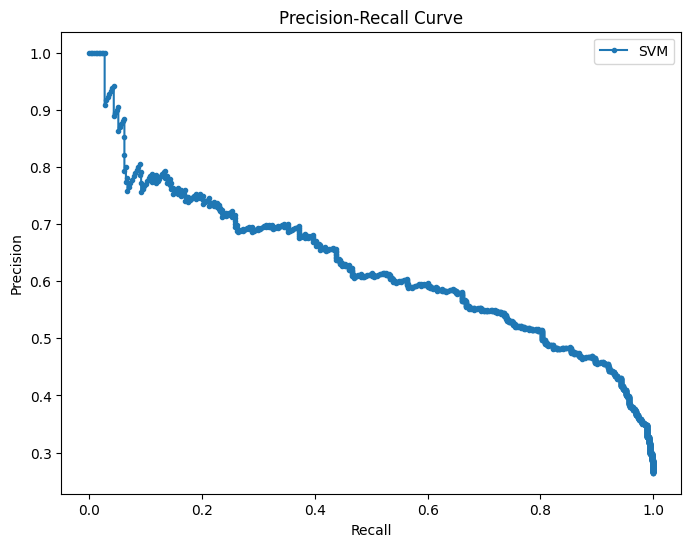

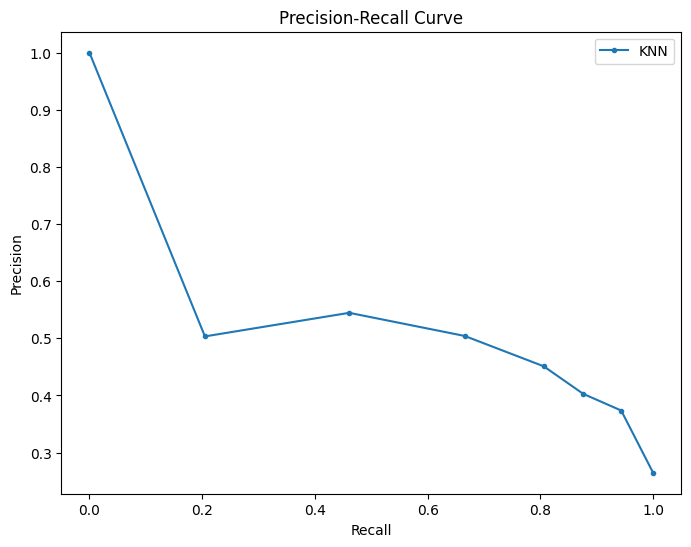

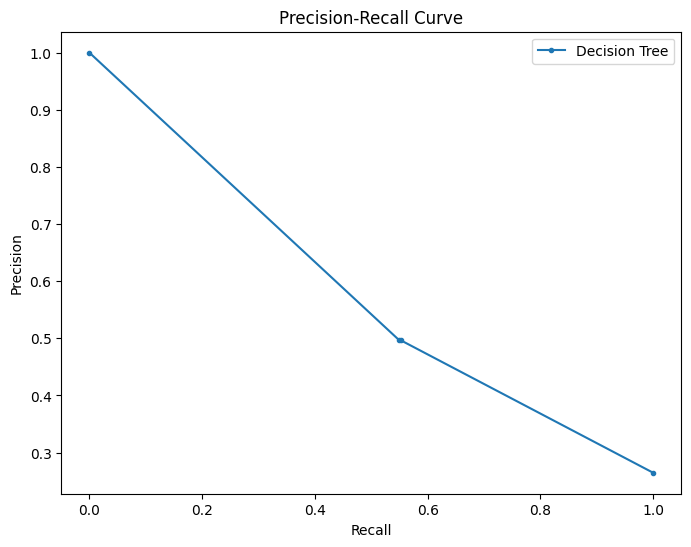

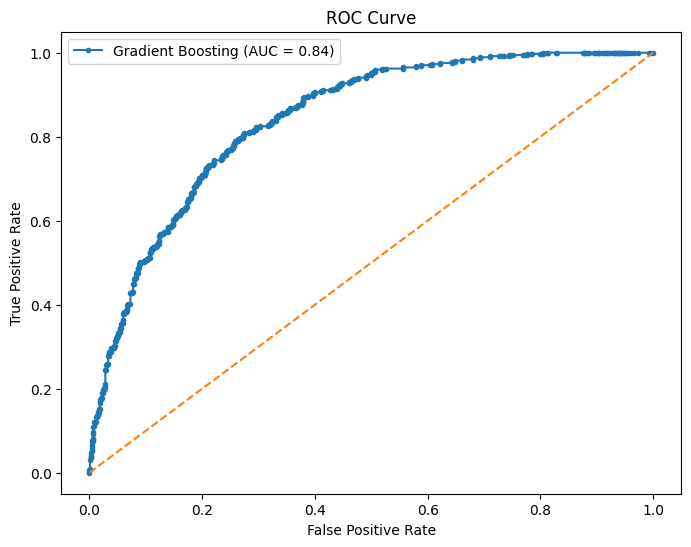

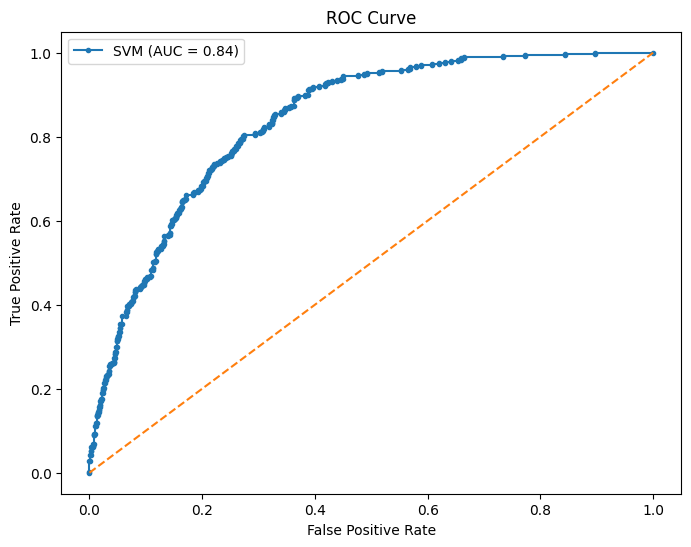

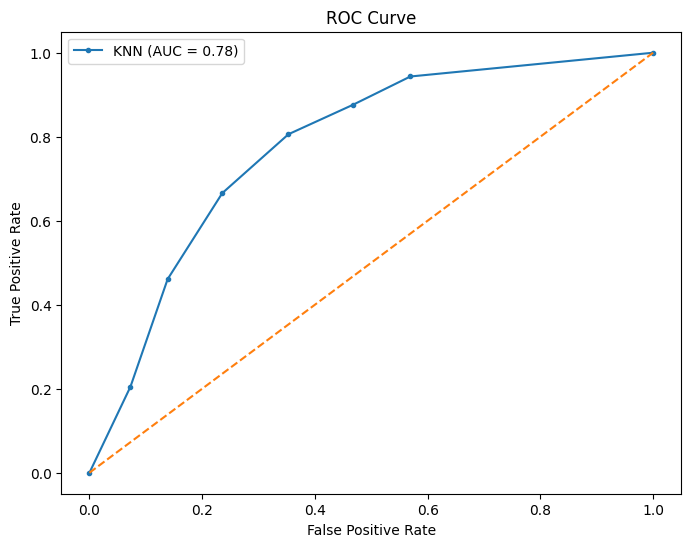

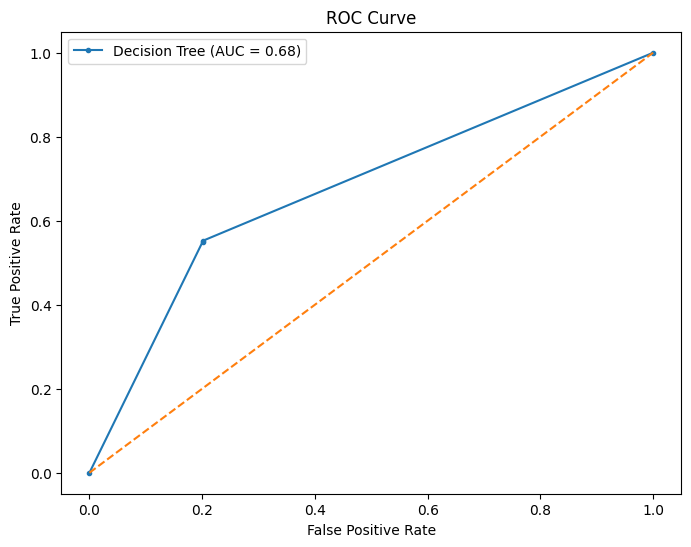

In [43]:
# Plot Precision-Recall curves
plot_precision_recall_curve(y_test, y_scores_gb, 'Gradient Boosting')
plot_precision_recall_curve(y_test, y_scores_svm, 'SVM')
plot_precision_recall_curve(y_test, y_scores_knn, 'KNN')
plot_precision_recall_curve(y_test, y_scores_dt, 'Decision Tree')

# Plot ROC curves
plot_roc_curve(y_test, y_scores_gb, 'Gradient Boosting')
plot_roc_curve(y_test, y_scores_svm, 'SVM')
plot_roc_curve(y_test, y_scores_knn, 'KNN')
plot_roc_curve(y_test, y_scores_dt, 'Decision Tree')


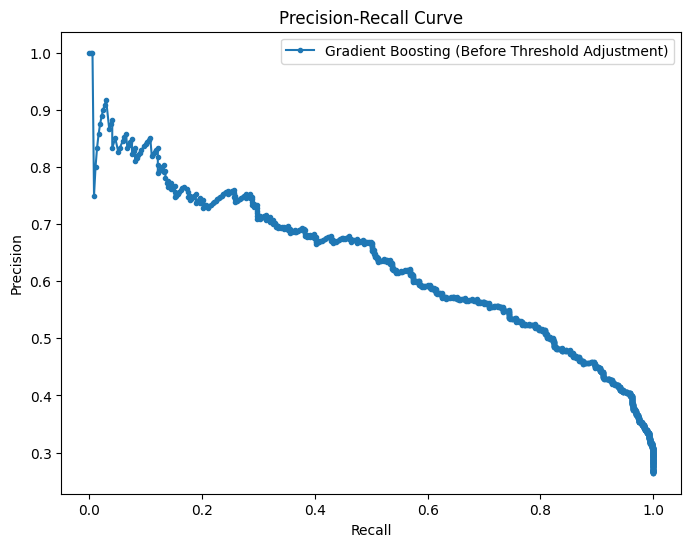

In [45]:
# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Plot Precision-Recall curve for Gradient Boosting before adjusting threshold
plot_precision_recall_curve(y_test, y_scores_gb, 'Gradient Boosting (Before Threshold Adjustment)')


In real world senarios we need to evaluate the classifier based on ther context. Based on the context it might be precission, fi or accuracy.